In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    """
    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['longitude','latitude'])): # if coordinates set this way...
        data2 = data.rename({'latitude': 'lat'})
        data2 = data2.rename({'longitude': 'lon'})
    else:
        data2 = data

    # check if latitutde is decreasing
    if (data2.lat[1] - data2.lat[0]) < 0:
        data2 = data2.reindex(lat=list(reversed(data2.lat))) # flipping latitude accoordingly

    # check if longitude is -180 to 180
    # if so, reconstructing into 0 to 360
    if (data2.lon.min() < 0):
        data2['lon'] = xr.where(data2['lon'] < 0, data2['lon'] + 360, data2['lon'])
        data2 = data2.sortby('lon')

    return data2

In [4]:
# bins for BL_CAPE and BL_SUBSAT
bins_cape = np.arange(-15,10,0.25) # (K)
bins_subsat = np.arange(-5,25,0.25)# (K)
bins_samples = np.zeros((len(bins_cape)-1, len(bins_subsat)-1)) # (cape, subsat)
prec_gpm_sum = np.copy(bins_samples)

In [5]:
buoy_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
gpm_dir = Path('/neelin2020/RGMA_feature_mask')
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/')

In [6]:
%%time
year_list = [2012,2013]

for year in year_list:
    
    files = sorted(list(buoy_dir.glob('*_{}_*.nc'.format(year))))
    for file in files[::10]:
        print(file.name)
        data_buoy = xr.open_dataset(file)
        # open monthly SP file
        month_str=file.name[-8:-6]
        data_sp = xr.open_dataset(era5_dir / '{}/era-5.sp.{}.{}.nc'.format(year,year,month_str))
        
        for t in range(len(data_buoy.time)):

            data = data_buoy.isel(time=t).sel(lat=slice(-30,30)) # tropics 30S-30N
            day = str(data.time.values)[8:10]
            hour = str(data.time.values)[11:13]
            
            timestamp = datetime(year,int(month_str),int(day),int(hour))
            
            try:

                thetae_bl = data.thetae_bl
                thetae_lt = data.thetae_lt
                thetae_sat_lt = data.thetae_sat_lt
                sp = data_sp.sel(time=timestamp, method='nearest').SP/100 # hPa
                sp = coordinates_processors(sp)
                # regrid to match buoyancy data
                sp = sp.sel(lat=slice(-30,30)).interp(lon=data.lon, lat=data.lat) # tropics 30S-30N

                delta_pl=sp-100-400
                delta_pb=100
                wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
                wl=1-wb

                BL_CAPE = wb*(thetae_bl - thetae_sat_lt)/thetae_sat_lt*340 # (K)
                BL_SUBSAT = wl*(thetae_sat_lt - thetae_lt)/thetae_sat_lt*340 # (K)

                # get GPM-IMERG hourly data
                data_gpm = xr.open_dataset(gpm_dir / 'GPM_ncfiles_{}/GPM_IMERGE_V06_{}{}{}_{}00.nc'.format(year,year,month_str,day,hour))
                prec_gpm = data_gpm.precipitationCal.isel(time=0) # a default time index
                prec_gpm = coordinates_processors(prec_gpm)
                prec_gpm = prec_gpm.sel(lat=slice(-30,30)).interp(lon=data.lon, lat=data.lat)

                # binning process
                cape_1d = BL_CAPE.values.ravel()
                subsat_1d = BL_SUBSAT.values.ravel()
                prec_gpm_1d = prec_gpm.values.swapaxes(1,0).ravel()

                for i in range(len(bins_cape)-1):
                    idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                    for j in range(len(bins_subsat)-1):
                        idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                        idx_com = np.intersect1d(idx,idy)
                        bins_samples[i,j] += len(idx_com)
                        prec_gpm_sum[i,j] += np.sum(prec_gpm_1d[idx_com])
                        
            except:
                
                print('error file')

# save into a xarray dataset            
ds_bins = xr.Dataset(data_vars = dict(samples = (['bins_cape','bins_subsat'], bins_samples),
                                  prec_gpm_sum = (['bins_cape','bins_subsat'], prec_gpm_sum)),
                     coords = dict(
                               bins_cape = (['bins_cape'], bins_cape[:-1]),
                               bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                     attrs = dict(description = 'GPM-IMERG conditional precipitation. All grids. No condition.'))           

era5_2layers_thetae_2012_01_01.nc
era5_2layers_thetae_2012_01_11.nc
era5_2layers_thetae_2012_01_21.nc
era5_2layers_thetae_2012_01_31.nc
era5_2layers_thetae_2012_02_10.nc
era5_2layers_thetae_2012_02_20.nc
era5_2layers_thetae_2012_03_01.nc
era5_2layers_thetae_2012_03_11.nc
era5_2layers_thetae_2012_03_21.nc
era5_2layers_thetae_2012_03_31.nc
era5_2layers_thetae_2012_04_10.nc
era5_2layers_thetae_2012_04_20.nc
era5_2layers_thetae_2012_04_30.nc
era5_2layers_thetae_2012_05_10.nc
era5_2layers_thetae_2012_05_20.nc
era5_2layers_thetae_2012_05_30.nc
era5_2layers_thetae_2012_06_09.nc
era5_2layers_thetae_2012_06_19.nc
era5_2layers_thetae_2012_06_29.nc
era5_2layers_thetae_2012_07_09.nc
era5_2layers_thetae_2012_07_19.nc
era5_2layers_thetae_2012_07_29.nc
era5_2layers_thetae_2012_08_08.nc
era5_2layers_thetae_2012_08_18.nc
era5_2layers_thetae_2012_08_28.nc
era5_2layers_thetae_2012_09_07.nc
era5_2layers_thetae_2012_09_17.nc
era5_2layers_thetae_2012_09_27.nc
era5_2layers_thetae_2012_10_07.nc
era5_2layers_t

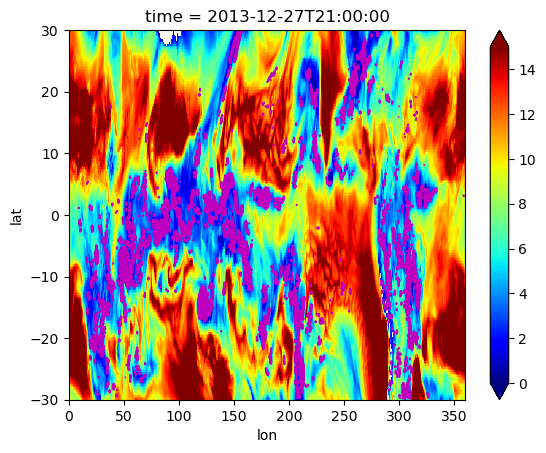

In [10]:
fig, ax = plt.subplots(1,1)
c=BL_SUBSAT.plot(ax=ax, y='lat', vmin=0, vmax=15, cmap='jet')
c=prec_gpm.plot.contour(ax=ax,y='lat',levels=np.linspace(1,20,19),colors=['m'],extend='both')
c.cmap.set_over('w')

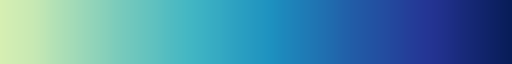

In [11]:
colors2 = plt.cm.YlGnBu(np.linspace(0.2, 1, 50))
# combine them and build a new colormap
mixedmap = LinearSegmentedColormap.from_list('mycolor',colors2)
mixedmap

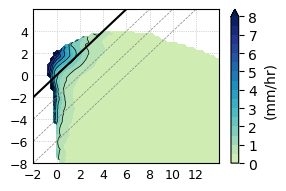

In [12]:
#### contribution of total rainfall 

fig, ax = plt.subplots(1,1,figsize=(3,2))

bins_cape = ds_bins.bins_cape
bins_subsat = ds_bins.bins_subsat

dbl = 0.25
prec_gpm_sum = ds_bins.prec_gpm_sum.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
samples_all = ds_bins.samples.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                           bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

prec_gpm_sum = prec_gpm_sum.where(samples_all > 200)

# conditional mean of gpm precip (mm/hr)
cp = ax.contourf(samples_all.bins_subsat, samples_all.bins_cape, prec_gpm_sum/samples_all, cmap=mixedmap,levels=np.linspace(0,8,17), zorder=2, extend='max')
ax.contour(samples_all.bins_subsat, samples_all.bins_cape, prec_gpm_sum/samples_all, colors='k', levels=np.linspace(0,8,9), zorder=2, linewidths=0.5)
cbar = plt.colorbar(cp,ax=ax)
cbar.set_label('(mm/hr)')

# add buoyancy reference 
ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1.5)
ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='grey', ls='--',lw=0.5)
ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='grey', ls='--',lw=0.5)
ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)

## configuration of tick, labels
#ax.text(-1.2,4.3,'{}'.format(phase),fontsize=9,color='k')
ax.grid(ls=':', lw=0.5, zorder=1)
ax.set_xticks([-2,0,2,4,6,8,10,12])
ax.set_yticks([-8,-6,-4,-2,0,2,4])
ax.tick_params(labelsize=9)
ax.tick_params('both', length=0, width=1, which='major')

# set x-y domain 
ax.set_ylim([-8,6])
ax.set_xlim([-2,14])  

plt.show()

In [13]:
ds_bins.to_netcdf('/scratch/wmtsai/temp_mcs/output_stats/BLhist2d_precipitation_uncondition.nc')